# Image Curation in NeMo Curator

In the following notebook, we'll be exploring all of the functionality that NeMo Curator has for image dataset curation.
NeMo Curator has a few built-in modules for:

1. CLIP Image Embedding Creation
1. Aesthetic Classification
1. Semantic Deduplication
1. Not Safe for Work (NSFW) Classification

We'll cover the first three modules in this tutorial notebook. First, we'll need to install NeMo Curator!

NOTE: Please ensure you meet the [requirements](https://github.com/NVIDIA/NeMo-Curator/tree/main?tab=readme-ov-file#install-nemo-curator) before proceeding!

## Table of Contents
1. [Download a Sample Dataset](#Download-a-Sample-Dataset)
2. [Install NeMo Curator](#Install-NeMo-Curator)
3. [Create CLIP Image Embeddings](#Create-CLIP-Image-Embeddings)
4. [Aesthetic Classifier](#Aesthetic-Classifier)
5. [Semantic Deduplication](#Semantic-Deduplication)

## Download a Sample Dataset
If you already have a dataset in webdataset format, great! You can skip to the [next section](#create-clip-embeddings).
In order to have a sample dataset to play with, we are going to download a subset of the [Microsoft Common Objects in Context (mscoco)](https://cocodataset.org/#home) dataset.
MSCOCO is a dataset of 600,000 image-text pairs (around 76GB) that takes around 20 minutes to download.
For the sake of this tutorial, we are only going to download a subset of the dataset.
We will download 20,000 image-text pairs (around 3GB).

To download the dataset, we are going to use a tool called [img2dataset](https://github.com/rom1504/img2dataset). Let's install it and download the dataset.

In [ ]:
!pip install img2dataset

First, we need to get a list of URLs that identify where all the images are hosted.

In [2]:
!wget https://huggingface.co/datasets/ChristophSchuhmann/MS_COCO_2017_URL_TEXT/resolve/main/mscoco.parquet

--2024-09-19 16:50:18--  https://huggingface.co/datasets/ChristophSchuhmann/MS_COCO_2017_URL_TEXT/resolve/main/mscoco.parquet
Resolving huggingface.co (huggingface.co)... 3.168.86.96, 3.168.86.52, 3.168.86.111, ...
Connecting to huggingface.co (huggingface.co)|3.168.86.96|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs.huggingface.co/datasets/ChristophSchuhmann/MS_COCO_2017_URL_TEXT/2c39f6d88edde6942b67e09eaa53b4f7b387b509f5affcc4f5a5da38081580e2?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27mscoco.parquet%3B+filename%3D%22mscoco.parquet%22%3B&Expires=1727023818&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTcyNzAyMzgxOH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy5odWdnaW5nZmFjZS5jby9kYXRhc2V0cy9DaHJpc3RvcGhTY2h1aG1hbm4vTVNfQ09DT18yMDE3X1VSTF9URVhULzJjMzlmNmQ4OGVkZGU2OTQyYjY3ZTA5ZWFhNTNiNGY3YjM4N2I1MDlmNWFmZmNjNGY1YTVkYTM4MDgxNTgwZTI%7EcmVzcG9uc2UtY29udGVudC1kaXNwb3NpdGlvbj0qIn1dfQ__&Si

We truncate this list of URLs so we don't download the whole dataset.

In [3]:
import pandas as pd

NUM_URLS = 20_000
urls = pd.read_parquet("mscoco.parquet")
truncated_urls = urls[:NUM_URLS]
truncated_urls.to_parquet("truncated_mscoco.parquet")

Now, let's start the download.

In [4]:
!img2dataset \
    --url_list truncated_mscoco.parquet \
    --input_format "parquet" \
    --output_folder mscoco \
    --output_format webdataset \
    --url_col "URL" \
    --caption_col "TEXT" \
    --processes_count 16 \
    --thread_count 64 \
    --resize_mode no

Starting the downloading of this file
Sharding file number 1 of 1 called /app/NeMo-Curator/tutorials/image-curation/truncated_mscoco.parquet
0it [00:00, ?it/s]File sharded in 2 shards
2it [01:26, 43.20s/it]
worker  - success: 1.000 - failed to download: 0.000 - failed to resize: 0.000 - images per sec: 121 - count: 10000
total   - success: 1.000 - failed to download: 0.000 - failed to resize: 0.000 - images per sec: 121 - count: 10000
worker  - success: 1.000 - failed to download: 0.000 - failed to resize: 0.000 - images per sec: 121 - count: 10000
total   - success: 1.000 - failed to download: 0.000 - failed to resize: 0.000 - images per sec: 242 - count: 20000


In [ ]:
import os

os._exit(0) # Shut down all kernels to prevent dependencies from conflicting

## Install NeMo Curator

In [ ]:
!pip install cython ipywidgets
# Install from source by default
!pip install --extra-index-url https://pypi.nvidia.com ../../[image]
%env DASK_DATAFRAME__QUERY_PLANNING False

## Create CLIP Image Embeddings

NeMo Curator's image classifiers take as input the embeddings generated from CLIP models' vision encoders.
Semantic deduplication also operates on image embeddings.
Therefore, the first step in image curation pipelines involves generating and storing the embeddings so they can be used for the downstream curation stages.

### Start the Dask Cluster
NeMo Curator runs on Dask and Dask-cuDF to distribute computation. You can read more about it [in the documentation](https://docs.nvidia.com/nemo-framework/user-guide/latest/datacuration/cpuvsgpu.html). All of the image curation modules are GPU-based, so we need to start a GPU-based local Dask cluster before we can use them.

In [2]:
from nemo_curator import get_client

client = get_client(cluster_type="gpu")

### Load the Dataset
Instead of operating on the images directly, most features in NeMo Curator take embeddings as inputs. So, as the first stage in the pipeline, we are going to generate embeddings for all the images in the dataset. To begin, let's load the dataset using NeMo Curator.

In [3]:
# Change the dataset path if you have your own dataset
dataset_path = "./mscoco"
# Change the unique identifier depending on your dataset
id_col = "key"

In [4]:
from nemo_curator.datasets import ImageTextPairDataset

dataset = ImageTextPairDataset.from_webdataset(dataset_path, id_col)
# Filter out any entries that failed to download
dataset.metadata = dataset.metadata[dataset.metadata["error_message"].isna()]

### Choose the Embedder
We can now define the embedding creation step in our pipeline. NeMo Curator has support for all [timm](https://pypi.org/project/timm/) models. NeMo Curator's aesthetic classifier is trained on embeddings from `vit_large_patch14_clip_quickgelu_224.openai`, so we will use that. This model is the weights of OpenAI's original [ViT-L/14 CLIP variant](https://huggingface.co/openai/clip-vit-large-patch14).

The cell below will do the following:
1. Download the model `vit_large_patch14_clip_quickgelu_224.openai`.
1. Automatically convert the image preprocessing transformations of `vit_large_patch14_clip_quickgelu_224.openai` from their PyTorch form to DALI.

In [5]:
from nemo_curator.image.embedders import TimmImageEmbedder

embedding_model = TimmImageEmbedder(
                    "vit_large_patch14_clip_quickgelu_224.openai",
                    pretrained=True,
                    batch_size=1024,
                    num_threads_per_worker=16,
                    normalize_embeddings=True,
                    autocast=False,
                )

pytorch_model.bin:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

We can now create embeddings for the whole dataset. It's important to understand what is going on internally in NeMo Curator so you can modify parameters appropriately.

Once the computation is triggered, the cell below will:
1. Load a shard of metadata (a `.parquet` file) onto each GPU you have available using Dask-cuDF.
1. Load a copy of `vit_large_patch14_clip_quickgelu_224.openai` onto each GPU.
1. Repeatedly load images into batches of size `batch_size` onto each GPU with a given threads per worker (`num_threads_per_worker`) using DALI.
1. The model is run on the batch (without `torch.autocast()` since `autocast=False`).
1. The output embeddings of the model are normalized since `normalize_embeddings=True`.


Since NeMo Curator uses Dask, the cell below will not cause the embeddings to be created. The computation will only begin once we inspect the output in the `dataset.metadata.head()` call or when we write to disk using `dataset.save_metadata()` or `dataset.to_webdataset()`.

In [6]:
# Dask is lazy, so this will not compute embeddings
dataset = embedding_model(dataset)

Since embedding creation can take a long time, we save the embeddings right after they are generated. `dataset.save_metadata()` will add a new column for the image embeddings in the existing `.parquet` files in the dataset directory.

In [7]:
# This triggers the computation
# You don't need to save and load normally, but we do it here so
# the embeddings aren't recomputed every time they are needed.
dataset.save_metadata()
dataset = ImageTextPairDataset.from_webdataset(dataset_path, id_col)
dataset.metadata.head()

/app/NeMo-Curator/tutorials/image-curation/mscoco/00000.tar - Embedding creation with vit_large_patch14_clip_quickgelu_224.openai:   0%|          | 0/10000 [00:00<?, ?it/s]/opt/conda/envs/rapids/lib/python3.10/site-packages/nvidia/dali/backend.py:99: Warning: nvidia-dali-cuda120 is no longer shipped with CUDA runtime. You need to install it separately. NPP is typically provided with CUDA Toolkit installation or an appropriate wheel. Please check https://docs.nvidia.com/cuda/cuda-quick-start-guide/index.html#pip-wheels-installation-linux for the reference.
  deprecation_warning(
[/opt/dali/dali/operators/reader/loader/webdataset_loader.cc:380] Index file not provided, it may take some time to infer it from the tar file
/app/NeMo-Curator/tutorials/image-curation/mscoco/00001.tar - Embedding creation with vit_large_patch14_clip_quickgelu_224.openai:   0%|          | 0/10000 [00:00<?, ?it/s]/opt/conda/envs/rapids/lib/python3.10/site-packages/nvidia/dali/backend.py:99: Warning: nvidia-dali-

,caption,url,key,status,error_message,width,height,original_width,original_height,exif,sha256,image_embedding
0,A man with a red helmet on a small moped on a ...,http://images.cocodataset.org/train2017/000000...,000000000,success,<NA>,640,360,640,360,{},d0d62a2eed6433c8d65bae1c8dca849eb678d35a8f415e...,"[0.047896094620227814, -0.01185801811516285, -..."
1,Man riding a motor bike on a dirt road on the ...,http://images.cocodataset.org/train2017/000000...,000000001,success,<NA>,640,360,640,360,{},d0d62a2eed6433c8d65bae1c8dca849eb678d35a8f415e...,"[0.047896094620227814, -0.01185801811516285, -..."
2,A man riding on the back of a motorcycle.,http://images.cocodataset.org/train2017/000000...,000000002,success,<NA>,640,360,640,360,{},d0d62a2eed6433c8d65bae1c8dca849eb678d35a8f415e...,"[0.047896094620227814, -0.01185801811516285, -..."
3,A dirt path with a young person on a motor bik...,http://images.cocodataset.org/train2017/000000...,000000003,success,<NA>,640,360,640,360,{},d0d62a2eed6433c8d65bae1c8dca849eb678d35a8f415e...,"[0.047896094620227814, -0.01185801811516285, -..."
4,A man in a red shirt and a red hat is on a mot...,http://images.cocodataset.org/train2017/000000...,000000004,success,<NA>,640,360,640,360,{},d0d62a2eed6433c8d65bae1c8dca849eb678d35a8f415e...,"[0.047896094620227814, -0.01185801811516285, -..."


## Aesthetic Classifier
With the embeddings now created, we can use the aesthetic classifier. This classifier assigns a score from 0 to 10 that corresponds to how aesthetically pleasing the image is. A score of 0 means that the image is not pleasant to look at, while a score of 10 is pleasant to look at. The exact classifier used is the `LAION-Aesthetics_Predictor V2`. More information on the model can be found here: https://laion.ai/blog/laion-aesthetics/.

The following cell will download the model to your local storage at `NEMO_CURATOR_HOME` (`/home/user/.nemo_curator`). The model is only 3.6MB.

In [8]:
from nemo_curator.image.classifiers import AestheticClassifier

aesthetic_dataset_path = "./aesthetic_dataset"
aesthetic_classifier = AestheticClassifier()

In [9]:
dataset = aesthetic_classifier(dataset)

After annotating with the aesthetic score, we can filter by the aesthetic score. Finally, we save the resulting filter dataset to a new webdataset.

Unlike `dataset.save_metadata()`, `dataset.to_webdataset()` will modify the tar files as well as the `.parquet` files. It will cause the tar files to be resharded and any entries that have an aesthetic score less than or equal to 6 will be removed.

In [10]:
dataset.metadata["passes_aesthetic_check"] = dataset.metadata["aesthetic_score"] > 6
dataset.to_webdataset(aesthetic_dataset_path, filter_column="passes_aesthetic_check")

/opt/conda/envs/rapids/lib/python3.10/site-packages/nemo_curator/image/classifiers/aesthetic.py:90: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weights = torch.load(self.m

Finished writing shard 00000.tar with parquet length 110 and tar length 330


### Visualize Results
Now that we have filtered our dataset based on aesthetic score, we can see what kinds of images are remaining.

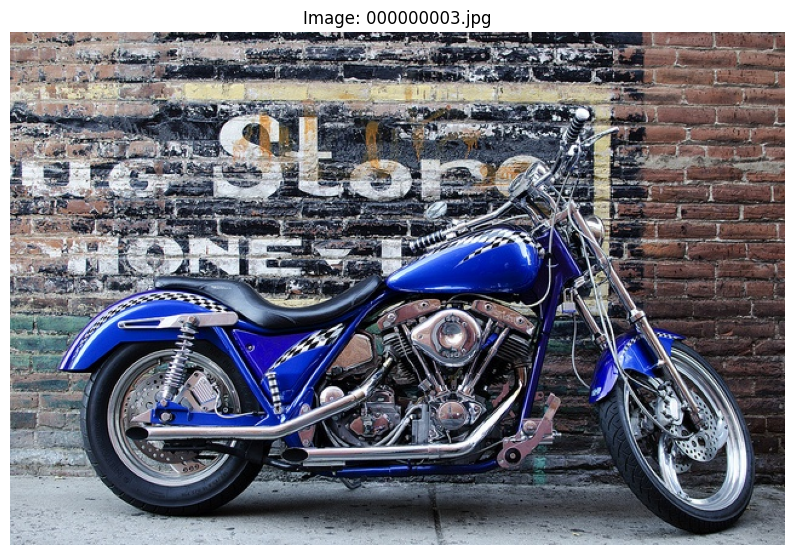

In [11]:
import tarfile
import io
from PIL import Image
import matplotlib.pyplot as plt
import os

def display_image_from_tar(tar_file_path, image_file_name):
    # Open the tar file
    with tarfile.open(tar_file_path, 'r') as tar:
        # Extract the specified image file
        image_file = tar.extractfile(image_file_name)
        
        if image_file is not None:
            # Read the image data
            image_data = image_file.read()
            
            # Create a PIL Image object from the image data
            image = Image.open(io.BytesIO(image_data))
            
            # Display the image using matplotlib
            plt.figure(figsize=(10, 8))
            plt.imshow(image)
            plt.axis('off')  # Hide axes
            plt.title(f"Image: {image_file_name}")
            plt.show()
        else:
            print(f"Image file '{image_file_name}' not found in the tar archive.")
    

output_shard = os.path.join(aesthetic_dataset_path, "00000.tar")
image_file_name = '000000003.jpg'
display_image_from_tar(output_shard, image_file_name)

## Semantic Deduplication

NeMo Curator provides an easy module for semantically deduplicating images. Semantic duplicates are images that contain almost the same information content, but are perceptually different. Two images of the same dog taken from slightly different angles would be considered semantic duplicates. NeMo Curator' semantic deduplication approach is based on the paper [SemDeDup: Data-efficient learning at web-scale through semantic deduplication](https://arxiv.org/pdf/2303.09540) by Abbas et al which has demonstrated that deduplicating your data can lead to the same downstream performance in *half* the number of training iterations. For more information on the algorithm, you can check out the [documentation page](https://docs.nvidia.com/nemo-framework/user-guide/latest/datacuration/semdedup.html#data-curator-semdedup).

### Parameter Choice
There are many options to configure how semantic deduplication behaves. The values below are appropriate for our dataset size, but it's worth mentioning how one might tweak them to scale to larger datasets. We'll focus on parameters that affect the k-means clustering step of semantic deduplication.
- `max_iter=10` defines the number of iterations of adjusting the cluster centroids. This value should be ~100 for datasets in the size of $10^6$ images.
- `n_clusters=1` defines the number of clusters. Duplicates are only considered within each cluster, so increasing the number of clusters reduces the number of duplicate comparisons made. This will reduce the computational burden, but also allow for more duplicates to slip through. This value should be ~50,000 for datasets in the size of $10^6$ images.

In [ ]:
import os
from nemo_curator.datasets import DocumentDataset
from nemo_curator import ClusteringModel, SemanticClusterLevelDedup

# Convert the dataset
embeddings_dataset = DocumentDataset(dataset.metadata)

semantic_dedup_outputs = "./semantic_deduplication"
os.makedirs(semantic_dedup_outputs, exist_ok=True)

# Run clustering
clustering_output = os.path.join(semantic_dedup_outputs, "cluster_output")
clustering_model = ClusteringModel(
    id_column=id_col,
    embedding_col="image_embedding",
    max_iter=10,
    n_clusters=1,
    clustering_output_dir=clustering_output,
)
clustered_dataset = clustering_model(embeddings_dataset)

2024-09-19 16:56:38,855 | f62f18cf1933 | Rank 0 | KMeans starting fit
2024-09-19 16:56:40,649 | f62f18cf1933 | Rank 0 | KMeans fit complete
2024-09-19 16:56:40,652 | f62f18cf1933 | Rank 0 | Computing nearest centroids + distance to centers using kmeans.predict
2024-09-19 16:56:40,744 | f62f18cf1933 | Rank 0 | Saving centroids complete
2024-09-19 16:56:44,143 | f62f18cf1933 | Rank 0 | Saved embeddings by nearest center to ./semantic_deduplication/cluster_output/embs_by_nearest_center
2024-09-19 16:56:44,146 | f62f18cf1933 | Rank 0 | Ranking...
2024-09-19 16:56:48,805 | f62f18cf1933 | Rank 0 | Completed 1 clusters. Missing 0 clusters.
2024-09-19 16:56:48,808 | f62f18cf1933 | Rank 0 | Time for ranking: 0.08 mins
2024-09-19 16:56:48,810 | f62f18cf1933 | Rank 0 | DONE!


In [ ]:
# Run cluster-level dedup
emb_by_cluster_output = os.path.join(clustering_output, "embs_by_nearest_center")
sorted_cluster_output = os.path.join(clustering_output, "sorted")
duplicate_output = os.path.join(semantic_dedup_outputs, "duplicates")

semantic_dedup = SemanticClusterLevelDedup(
    n_clusters=1,
    emb_by_clust_dir=emb_by_cluster_output,
    sorted_clusters_dir=sorted_cluster_output,
    id_column=id_col,
    id_column_type="str",
    embedding_col="image_embedding",
    which_to_keep="hard",
    output_dir=duplicate_output,
)
semantic_dedup.compute_semantic_match_dfs([0.01, 0.001])
deduplicated_dataset_ids = semantic_dedup.extract_dedup_data(eps_to_extract=0.01)

2024-09-19 16:56:49,966 | f62f18cf1933 | Rank 0 | DONE saving 3995 out of 20000. Removed: 16005. Epsilon: 0.0100
2024-09-19 16:56:49,966 | f62f18cf1933 | Rank 0 | DONE saving 3995 out of 20000. Removed: 16005. Epsilon: 0.0100


Reading 1 files


### Remove Duplicates

We got a list of deduplicated image IDs. Now we can remove entries with those IDs from our dataset, and reshard the dataset to remove them from the tar files.

In [14]:
# Remove duplicates
deduplicated_dataset_path = "./deduplicated_dataset"
dataset.metadata["is_unique"] = dataset.metadata["key"].isin(deduplicated_dataset_ids.df["key"].compute())
dataset.to_webdataset(deduplicated_dataset_path, "is_unique")

Finished writing shard 00000.tar with parquet length 3995 and tar length 11985


### Visualize Duplicates

To better understand what we did in semantic deduplication, let's examine the output of an intermediate step and visualize some of the duplicates NeMo Curator removed.

In [15]:
import pandas as pd
import os

cluster_path = os.path.join(duplicate_output, "semdedup_pruning_tables", "cluster_0.parquet")
df = pd.read_parquet(cluster_path)
df = df[~df["eps=0.001"]]
df = df.sort_values("cosine_sim_score", ascending=False)
df.head()

,indices,id,max_id,cosine_sim_score,eps=0.01,eps=0.001
8558,8558,000003838,000003833,0.995424,True,False
18909,18909,000008687,000008672,0.991162,True,False
11065,11065,000000020,000000015,0.989709,False,False
18059,18059,000008682,000008672,0.988220,False,False
7667,7667,000008582,000008577,0.987734,False,False


Let's examine what the columns mean.
1. The `id` column represents the ID of the datapoint.
1. `max_id` represents the ID of the image that `id` is the most similar to.
1. `cosine_sim_score` is the cosine similarity, where `1` indicates the two images are exactly the same and `0` means the images are completely different.
1. `eps=0.01` is `True` if `cosine_sim_score` is `>= 0.99`.
1. `eps=0.001` is `True` if `cosine_sim_score` is `>= 0.999`.

This dataset has a lot of exact duplicates, so those are caught by `eps=0.001`. We have filtered out the IDs so we don't see them here. There are still a few documents that are similar, but not exact duplicates. We can examine `000008687.jpg` and `000008672.jpg` using our helper function from earlier to see what they look like.

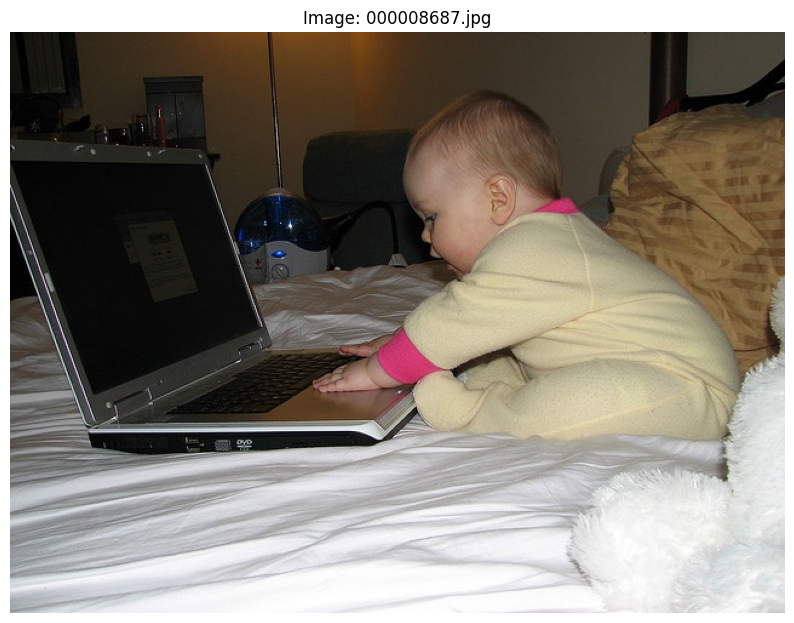

In [16]:
input_shard = os.path.join(dataset_path, "00000.tar")

display_image_from_tar(input_shard, "000008687.jpg")

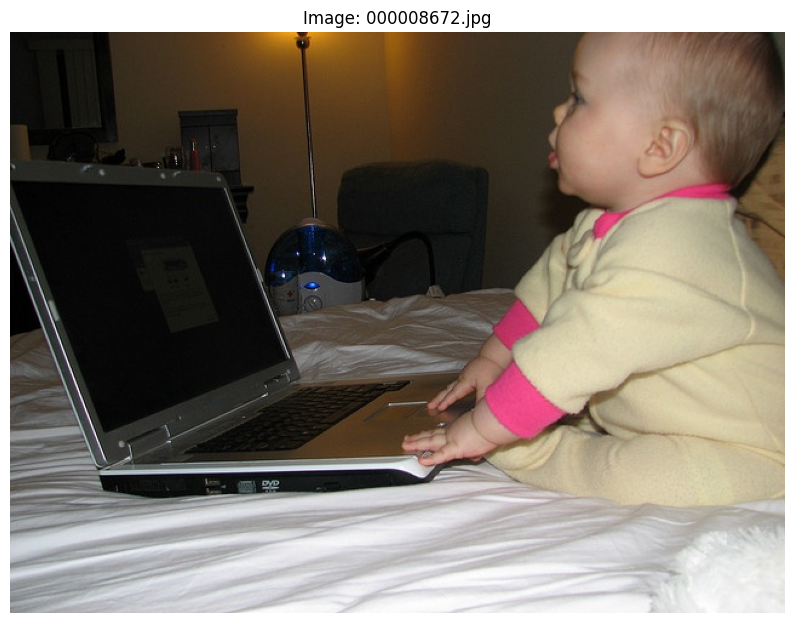

In [17]:
display_image_from_tar(input_shard, "000008672.jpg")

Here, we can see that the images are different. Notably, the baby's head is looking in a different direction. Despite the small differences, these images would still be considered semantic duplicates. Feel free to adjust the epsilon threshold and see what kinds of images are considered duplicates.